# NV-Ingest: Python Client Quick Start Guide

This notebook provides a quick start guide to using the NV-Ingest Python API to create a client that interacts with a running NV-Ingest cluster. It will walk through the following:

- Instantiate a client object
- Define the task configuration for an NV-Ingest job
- Submit a job the the NV-Ingest cluster
- Retrieve completed results
- Investigate the multimodal extractions


Specify a few parameters to connect to our nv-ingest cluster and a notional document to guide the examples.

In [1]:
import os

# client config
HTTP_HOST = os.environ.get('HTTP_HOST', "nv-ingest-ms-runtime")
HTTP_PORT = os.environ.get('HTTP_PORT', "7670")
TASK_QUEUE = os.environ.get('TASK_QUEUE', "morpheus_task_queue")

# minio config
MINIO_ACCESS_KEY = os.environ.get('MINIO_ACCESS_KEY', "minioadmin")
MINIO_SECRET_KEY = os.environ.get('MINIO_SECRET_KEY', "minioadmin")

# time to wait for job to complete
DEFAULT_JOB_TIMEOUT = 90

# sample input file and output directory
SAMPLE_PDF = "/raid/workspace/nv-ingest/data/multimodal_test.pdf"

## The NV-Ingest Python Client

In [2]:
from base64 import b64decode
import time

from nv_ingest_client.client import NvIngestClient
from nv_ingest_client.message_clients.rest.rest_client import RestClient
from nv_ingest_client.primitives import JobSpec
from nv_ingest_client.primitives.tasks import DedupTask
from nv_ingest_client.primitives.tasks import EmbedTask
from nv_ingest_client.primitives.tasks import ExtractTask
from nv_ingest_client.primitives.tasks import FilterTask
from nv_ingest_client.primitives.tasks import SplitTask
from nv_ingest_client.primitives.tasks import StoreTask, StoreEmbedTask
from nv_ingest_client.primitives.tasks import VdbUploadTask
from nv_ingest_client.util.file_processing.extract import extract_file_content

from IPython import display

Load a sample PDF to demonstrate NV-Ingest usage.

In [3]:
file_content, file_type = extract_file_content(SAMPLE_PDF)

Initialize a client that will submit jobs to our NV-Ingest cluster.

In [4]:
client = NvIngestClient(
    message_client_allocator=RestClient,
    message_client_hostname=HTTP_HOST,
    message_client_port=HTTP_PORT,
    message_client_kwargs=None,
    msg_counter_id="nv-ingest-message-id",
    worker_pool_size=1,
)

A `JobSpec` is a specification for creating a job for submission to the NV-Ingest microservice. It accepts the following parameters:

- `document_type` : The file type of the file to be ingested.
- `payload` : A base64 encoded string of the file to be ingested.
- `source_id` : An identifier that maps to the file, our example uses the filename here.
- `source_name` : The name of the source for this ingest job, again, we use the filename.
- `extented_options` : A dictionary of additional options to pass in to the ingest job, we pass in informations allowing us to conduct performance tracing of the job.


In [5]:
job_spec = JobSpec(
    document_type=file_type,
    payload=file_content,
    source_id=SAMPLE_PDF,
    source_name=SAMPLE_PDF,
    extended_options={
        "tracing_options": {
            "trace": True,
            "ts_send": time.time_ns(),
        }
    },
)

Each ingest job will include a set of tasks. These tasks will define the operations that will be performed during ingestion. This allows each job to potentially have different ingestion instructions. Here we define a simple extract oriented job, but the full list of supported options are contained below:

- `ExtractTask` : Performs multimodal extractions from a document, including text, images, and tables.
- `SplitTask` : Chunk the text into smaller chunks, useful for storing in a vector database for retrieval applications.
- `Dedup` : Identifies duplicate images in document that can be filtered to remove data redundancy.
- `Filter` : Filters out images that are likely not useful using some heuristics, including size and aspect ratio.
- `EmbedTask` : Pass the text or table extractions through `"nvidia/nv-embedqa-e5-v5` NIM to obtain its embeddings.
- `Store` : Save the extracted tables or images to an S3 compliant object store like MinIO.
- `Upload` : Save embeddings, chunks, and metadata to a Milvus vector database.

After defining the ingestion tasks, they must be added to the job specification.

In [6]:
extract_task = ExtractTask(
    document_type=file_type,
    extract_text=True,
    extract_images=True,
    extract_tables=True,
    text_depth="document",
    extract_tables_method="yolox",
)

dedup_task = DedupTask(
    content_type="image",
    filter=True,
)

filter_task = FilterTask(
    content_type="image",
    min_size=128,
    max_aspect_ratio=5.0,
    min_aspect_ratio=0.2,
    filter=True,
)

job_spec.add_task(extract_task)
job_spec.add_task(dedup_task)
job_spec.add_task(filter_task)

A job identifier is created for the job specification. This is used to retrieve the results upon completion.

With the `job_id`, the job is submitted to the NV-Ingest microservice. When the job is complete, the results are fetched.

Note, many jobs can be submitted and asynchronous execution is supported.

In [7]:
job_id = client.add_job(job_spec)
client.submit_job(job_id, TASK_QUEUE)
generated_metadata = client.fetch_job_result(
    job_id, timeout=DEFAULT_JOB_TIMEOUT
)[0][0]

In [18]:
generated_metadata[1]

{'document_type': 'structured',
 'metadata': {'content': 'iVBORw0KGgoAAAANSUhEUgAAA5UAAAC5CAIAAAA3TIxUAADYrUlEQVR4nOydZ3wVxffwZ/f2mt57SCMhhZAGIQQCofdexEJRpIjCD1CkqkhTpAgKqFjo0iHSi7RAEkJISEglvfd2+737vDj/7LPem4SASnO+L/iEubMzs7NzZs7MnDlDUBSF2uD+/fv19fX+/v4mJiYURREEAf/m5eXl5eV5enra2NhACEKoubk5Pj7e2Ng4ICAAAtPT08vKyvz8/ExNTSEXgiBKSkoSEhKys7M5HI63t3dISIhEIqETYUIHPnz4sKamhsfjBQYGstlsgiDy8/Nv3LhRXl7u5uYWGRlpbGyclZVVXFzctWtXIyMjhFBDQ0NiYqKDg0OnTp1SU1NjY2Plcrm3t3dERASXy9XLrqCgID8/39zcvHPnzvRPaWlpCQkJFRUVNjY2QUFBnp6ebdUSPFJfX//nn38+fvzY0tIyIiLCwcEhMzOzpKSkW7du8ILw+gihlJSUe/fuVVVV2dnZBQcHu7m56SVVU1MTFxeXkZFBUZSHh0dISIi5uTldMJ1OR5JkVVVVbGxsTk6OWCz29/cPDg6GxyGX/Pz83Nxcd3d3Ozs75sumpKRUV1cHBgZKpVL6k1lbW3t5eWVmZt66dauxsdHT0zMiIkIoFNIP0n88evQoISGhvLzc2to6ODiYWScQp7y8PD4+Pisri8Vide7cOSQkxMjIqJ2PW1ZWFh8fn52dzWazIb5UKtXLt7S0NDY2Nj8/H5pW165dmUVSq9Xx8fEEQQQHB7PZbDr9Bw8e1NbW6lV+Tk5OYWGht7e3paWl3nvFx8dXVFQYvlerDfLmzZv379/ncDhBQUFBQUEIoevXr0skEigbLTjBwcEikYh+sKSkJDMz09nZ2dnZGb5jfHy8Wq0OCQnhcrkIocrKytTUVDs7O3d3dz

## Explore the Outputs

Let's explore elements of the NV-Ingest output. When data flows through an NV-Ingest pipeline, a number of extractions and transformations are performed. As the data is enriched, it is stored in rich metadata hierarchy. In the end, there will be a list of dictionaries, each of which represents a extracted type of information. The most common elements to extract from a dictionary in this hierarchy are the extracted content and the text representation of this content. The next few cells will demonstrate interacting with the metadata, pulling out these elements, and visualizing them. Note, when there is a `-1` value present, this represents non-applicable positional resolution. Positive numbers represent valid positional data.

For a more complete description of metadata elements, view the data dictionary.

[https://github.com/NVIDIA/nv-ingest/blob/main/docs/content-metadata.md](https://github.com/NVIDIA/nv-ingest/blob/main/docs/content-metadata.md)

In [8]:
def redact_metadata_helper(metadata: dict) -> dict:
    """A simple helper function to redact `metadata["content"]` so improve readability."""
    
    text_metadata_redact = text_metadata.copy()
    text_metadata_redact["content"] = "<---Redacted for readability--->"
    
    return text_metadata_redact

### Explore Output - Text

This cell depicts the full metadata hierarchy for a text extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, text in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source document that is the basis of the ingest job.
- `text_metadata` - Contain information about the text extraction, including detected language, among others - this section will only exist when `metadata['content_metadata']['type'] == 'text'`

In [9]:
text_metadata = generated_metadata[3]["metadata"]
redact_metadata_helper(text_metadata)

{'content': '<---Redacted for readability--->',
 'content_metadata': {'description': 'Structured table extracted from PDF document.',
  'hierarchy': {'block': -1,
   'line': -1,
   'nearby_objects': {'images': {'bbox': [], 'content': []},
    'structured': {'bbox': [], 'content': []},
    'text': {'bbox': [], 'content': []}},
   'page': 1,
   'page_count': 3,
   'span': -1},
  'page_number': 1,
  'subtype': 'table',
  'type': 'structured'},
 'debug_metadata': None,
 'embedding': None,
 'error_metadata': None,
 'image_metadata': None,
 'info_message_metadata': None,
 'raise_on_failure': False,
 'source_metadata': {'access_level': 1,
  'collection_id': '',
  'date_created': '2024-10-23T01:08:42.902475',
  'last_modified': '2024-10-23T01:08:42.902325',
  'partition_id': -1,
  'source_id': '/raid/workspace/nv-ingest/data/multimodal_test.pdf',
  'source_location': '',
  'source_name': '/raid/workspace/nv-ingest/data/multimodal_test.pdf',
  'source_type': 'PDF',
  'summary': ''},
 'table_met

View the text extracted from the sample document.

In [10]:
text_metadata["content"]

'iVBORw0KGgoAAAANSUhEUgAAA5YAAADnCAIAAADq/17QAAEAAElEQVR4nOx9d1wVx/f27N5K770KKoigYsUO9l6+lti7saUZ04wmRo0majS2mKLGHnuJCjZELAiiIqL0Jl16u1xu3Xn/OC/z29wLiMYkmMzzB5/L7uzM7OwzZ86cOXOGwRijBqDVcgIBeyX68YiPN3KY2/rezHfHD9FotSzDsiyTkJnbY/GXVbLa/p18t38wq427E3lQoVK3mbL0WUHxxiXTPp4yUq3RioSC2et/3H/uWo/OfuHbvxQJBRghBkrhOJZh1+4/vWrvCTsri4hdqz2d7BBCE774/tSV2wN7drq8+XOWZaAyCzbt/uX0le4dfO7+tKahar8QGi0nFLBP0rOnrd0Zl5Tp7Gj76/IFA7u002q1AoHglbOloKCgoKCgoKD4eyB8hWcwwggxwZGPqqpqbKzMt74/s427k0bLMQzCGHMY19QqEMPU+6SQZYVCAYcxU5eAQYhh0JOMbISxlYmRg5V5XVq4y0Bx8G/bFs5IIMgsKM4uLHGwtmAwYlgGIQSKeE5haVx6tpFU0t2vtZFUQrRkPkB/vRWbOHPdrmc5z9u0dDv0xeJOXh4aLSek+isFBQUFBQUFxZsA9pWfLK6oQhxnZWrs6WSn1mhBI8UYiYXC7KLSarmCZVm+gRdjxIhFzwqK0nOfswyj1mi0HKfWaBHDVNXIn6TnMIhp7eJgKJVotFqEkFQkQiwrUygwRhqtlsMcQqi7b2sTI8Oyyqor9x6LBAItxgxiGMRotZxQIPjl/PUxS1bN3fCzXKH8/0X+ERyHhQL23K37/1u55VlOQQ//Nhc3fNzJy0Oj1QpYBvPwys1CQUFBQUFBQUHxV+NVVFhQ8KzMjDHLllRWJWXliYQCAcsKWFYkFDxKeTZuxRa5UsmwDF+JxBizQmFBWeWMr3fll5SJhUJIzzLMpt8uZBUWI5Yd2asTQkjLcQghF1srRiRMzyt

### Explore Output - Tables

This cell depicts the full metadata hierarchy for a table extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, a base64 encoded image of the extracted table in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source and storage path of an extracted table in an S3 compliant object store.
- `table_metadata` - Contains the text representation of the table, positional data, and other useful elements - this section will only exist when `metadata['content_metadata']['type'] == 'structured'`.

Note, `table_metadata` will store chart and table extractions. The are distringuished by `metadata['content_metadata']['subtype']`

In [11]:
table_metadata = generated_metadata[4]["metadata"]
redact_metadata_helper(table_metadata)

{'content': '<---Redacted for readability--->',
 'content_metadata': {'description': 'Structured table extracted from PDF document.',
  'hierarchy': {'block': -1,
   'line': -1,
   'nearby_objects': {'images': {'bbox': [], 'content': []},
    'structured': {'bbox': [], 'content': []},
    'text': {'bbox': [], 'content': []}},
   'page': 1,
   'page_count': 3,
   'span': -1},
  'page_number': 1,
  'subtype': 'table',
  'type': 'structured'},
 'debug_metadata': None,
 'embedding': None,
 'error_metadata': None,
 'image_metadata': None,
 'info_message_metadata': None,
 'raise_on_failure': False,
 'source_metadata': {'access_level': 1,
  'collection_id': '',
  'date_created': '2024-10-23T01:08:42.902475',
  'last_modified': '2024-10-23T01:08:42.902325',
  'partition_id': -1,
  'source_id': '/raid/workspace/nv-ingest/data/multimodal_test.pdf',
  'source_location': '',
  'source_name': '/raid/workspace/nv-ingest/data/multimodal_test.pdf',
  'source_type': 'PDF',
  'summary': ''},
 'table_met

Visualize the table contained within the extracted metadata.

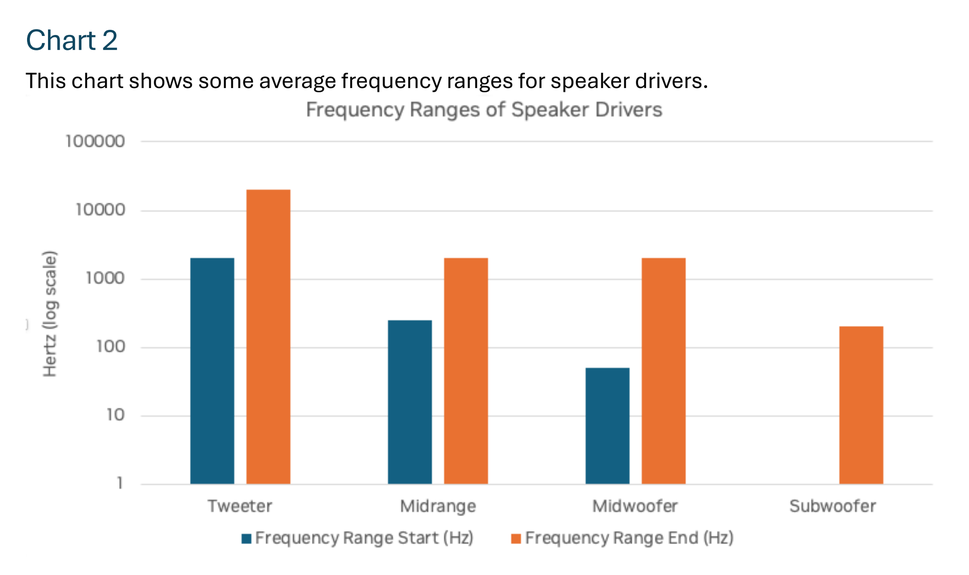

In [12]:
display.Image(b64decode(table_metadata["content"]))

View the corresponding text that maps to this table. This text could be embedded to support multimodal retrieval workflows.

In [13]:
table_metadata["table_metadata"]["table_content"]

'This chart shows some average frequency ranges for speaker drivers |TITLE | Chart 2 |\n|---|---|\n| Frequency Range Start (Hz) | Frequency Range Start (Hz) | Frequency Range End (Hz) |\n| Tweeter | 125.3 | 12530 |\n| Midrange | 1390 | 12530 |\n| Midwoofer | 170.7 | 12530 |\n| Subwoofer | 90.7 | 12527|    Tweeter - Midrange - Midwoofer - Subwoofer Hertz (log scale) 10 - 100 - 1000 - 10000 - 100000 Frequency Range Start (Hz) - Frequency Range End (Hz)    This chart shows some average frequency ranges for speaker drivers - Frequency Ranges of Speaker Drivers'

### Explore Output - Charts

This cell depicts the full metadata hierarchy for a chart extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, a base64 encoded image of the extracted chart in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source and storage path of an extracted chart in an S3 compliant object store.
- `table_metadata` - Contains the text representation of the chart, positional data, and other useful elements - this section will only exist when `metadata['content_metadata']['type'] == 'structured'`.

Note, `table_metadata` will store chart and table extractions. The are distringuished by `metadata['content_metadata']['subtype']`

In [14]:
chart_metadata = generated_metadata[5]["metadata"]
chart_metadata_redact = chart_metadata.copy()
chart_metadata_redact["content"] = "<---Redacted for readability--->"
chart_metadata_redact

IndexError: list index out of range

Visualize the chart contained within the extracted metadata.

In [ ]:
display.Image(b64decode(chart_metadata["content"]))

View the corresponding text that maps to this chart. This text could be embedded to support multimodal retrieval workflows.

In [ ]:
chart_metadata["table_metadata"]["table_content"]

### Explore Output - Images

This cell depicts the full metadata hierarchy for a image extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, a base64 encoded image extracted from the document in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source and storage path of an extracted image in an S3 compliant object store.
- `image_metadata` - Contains the image type, positional data, and other useful elements - this section will only exist when `metadata['content_metadata']['type'] == 'image'`.

In [ ]:
img_metadata = generated_metadata[1]["metadata"]
redact_metadata_helper(img_metadata)

Visualize the image contained within the extracted metadata.

In [ ]:
display.Image(b64decode(img_metadata["content"]))

### Optional:  Expanded Task Configuration

This section illustrates usage of the remaining task types used when supporting retrieval workflows.

- `StoreTask` - Stores extracted content to an S3 compliant object store (MinIO by default) and updates the `source_metadata` with the corresponding stored location.
- `EmbedTask` - Computes an embedding for the extracted content using a [`nvidia/nv-embedqa-e5-v5`](https://catalog.ngc.nvidia.com/orgs/nim/teams/nvidia/containers/nv-embedqa-e5-v5) NVIDIA Inference Microservice (NIM) by default.
- `VdbUploadTask` - Inserts ingested content into a Milvus vector database to support retrieval use cases.

Define the ingest job specification.

In [27]:
job_spec = JobSpec(
    document_type=file_type,
    payload=file_content,
    source_id=SAMPLE_PDF,
    source_name=SAMPLE_PDF,
    extended_options={
        "tracing_options": {
            "trace": True,
            "ts_send": time.time_ns(),
        }
    },
)

Here the task configuration is expanded, but requires the ancillary services (Embedding NIM, MinIO object stor, and Milvus Vector Database) to be up and running to return metadata back to the client.

In [29]:
extract_task = ExtractTask(
    document_type=file_type,
    extract_text=True,
    extract_images=True,
    extract_tables=True,
    text_depth="document",
    extract_tables_method="yolox",
)

dedup_task = DedupTask(
    content_type="image",
    filter=True,
)

filter_task = FilterTask(
    content_type="image",
    min_size=128,
    max_aspect_ratio=5.0,
    min_aspect_ratio=0.2,
    filter=True,
)

split_task = SplitTask(
    split_by="word",
    split_length=300,
    split_overlap=10,
    max_character_length=5000,
    sentence_window_size=0,
)

store_task = StoreTask(
    structured=True,
    images=True,
    store_method="minio",
    extra_params={
        "access_key": MINIO_ACCESS_KEY, 
        "secret_key": MINIO_SECRET_KEY,
    }
)

embed_task = EmbedTask(
    text=True,
    tables=True,
)

store_embed_task = StoreEmbedTask(
    embedding=True,
    store_method="minio",
    extra_params={
        "access_key": MINIO_ACCESS_KEY, 
        "secret_key": MINIO_SECRET_KEY,
    }
)

vdb_upload_task = VdbUploadTask(
    bulk_ingest=True,
    bulk_ingest_path="embeddings/",
    extra_args={
        "access_key": MINIO_ACCESS_KEY, 
        "secret_key": MINIO_SECRET_KEY,
    }
)

job_spec.add_task(extract_task)
job_spec.add_task(dedup_task)
job_spec.add_task(filter_task)
job_spec.add_task(store_task)
job_spec.add_task(embed_task)
job_spec.add_task(store_embed_task)
job_spec.add_task(vdb_upload_task)

TypeError: VdbUploadTask.__init__() got an unexpected keyword argument 'bulk_ingest'

A job identifier is created for the job specification. This is used to retrieve the results upon completion.

With the `job_id`, the job is submitted to the NV-Ingest cluster. When the job is complete, the results are fetched.

In [25]:
job_id = client.add_job(job_spec)
client.submit_job(job_id, TASK_QUEUE)
generated_metadata = client.fetch_job_result(
    job_id, timeout=DEFAULT_JOB_TIMEOUT
)[0][0]

In [26]:
generated_metadata

[{'document_type': 'text',
  'metadata': {'content': 'TestingDocument\r\nA sample document with headings and placeholder text\r\nIntroduction\r\nThis is a placeholder document that can be used for any purpose. It contains some \r\nheadings and some placeholder text to fill the space. The text is not important and contains \r\nno real value, but it is useful for testing. Below, we will have some simple tables and charts \r\nthat we can use to confirm Ingest is working as expected.\r\nTable 1\r\nThis table describes some animals, and some activities they might be doing in specific \r\nlocations.\r\nAnimal Activity Place\r\nGira@e Driving a car At the beach\r\nLion Putting on sunscreen At the park\r\nCat Jumping onto a laptop In a home o@ice\r\nDog Chasing a squirrel In the front yard\r\nChart 1\r\nThis chart shows some gadgets, and some very fictitious costs. Section One\r\nThis is the first section of the document. It has some more placeholder text to show how \r\nthe document looks lik